# Multi-View-Majority-Vote-Learning-Algorithms-Direct-Minimization-of-PAC-Bayesian-Bounds

This Notebook contains everything necessary to reproduce the experiments in our paper:  

*Multi-View Majority Vote Learning Algorithms: Direct Minimization of PAC-Bayesian Bounds*

## Imports

In [1]:
# %pip install -r requirements.txt

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from termcolor import colored

# Scikit-learn
from sklearn import preprocessing
from sklearn.utils import check_random_state
RAND = check_random_state(42)

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from mvpb.dNDF import MultiViewBoundsDeepNeuralDecisionForests


# Import data
from mvlearn.datasets import load_UCImultifeature
from data import (SampleData,
                           Nhanes,
                           MultipleFeatures,
                           MNIST_MV_Datasets,
                           Fash_MNIST_MV_Datasets,
                           EMNIST_Letters_MV_Datasets,
                           Mushrooms,
                           PTB_XL_plus,
                           Nutrimouse,
                           ReutersEN,
                           IS,
                           CorelImageFeatures,
                           NUS_WIDE_OBJECT,
                           ALOI,
                           train_test_split,
                           train_test_merge,
                           s1_s2_split,
                           multiclass_to_binary,
                           balance_dataset,
                           other_binary_options,
                           poison_dataset)
from mvpb.util import uniform_distribution

## Load and prepare the multiview datasets

In [2]:
dataset = MNIST_MV_Datasets(sample=1)
X_train, y_train, X_test, y_test = dataset.get_data()
# real_classes = dataset.get_real_classes(np.unique(y_train))

Xs_train = []
Xs_test = []
for xtr, xts in zip(X_train, X_test):
    scaler = preprocessing.MinMaxScaler().fit(xtr)
    Xs_train.append(scaler.transform(xtr))
    Xs_test.append(scaler.transform(xts))

X_train_concat = [np.concatenate(Xs_train, axis=1)]
X_test_concat = [np.concatenate(Xs_test, axis=1)]

np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [3]:
X_train[1].shape, y_train.shape, X_test[1].shape, y_test.shape

((56000, 196), (56000,), (14000, 196), (14000,))

In [4]:
RUNS = range(5)

OPTIMIZE_LAMBDA_GAMMA = True
ALPHA = [1, 0.5, 1.1, 2]
# ALPHA = [1.1]
MAX_ITER = 1500

stump_config = {
    "name": "stump",
    "n_estimators": 500,
    "max_depth": 1,
    "max_features": 0.5,
}
weak_learners_config = {
    "name": "weak_learner",
    "n_estimators": 500,
    "max_depth": 3,
    "max_features": 0.5,
}
strong_learners_config = {
    "name": "strong_learner",
    "n_estimators": 500,
    "max_depth": 6,
    "max_features": 0.8,
}

# CFG = [stump_config, weak_learners_config, strong_learners_config]
CFG = [weak_learners_config]

EPOCHS = 15

TO_BINARY  = "ovo" # One of ["ovr", "ovo", "other",  None]
label_1 = 4 #np.unique(y_test)[np.where(real_classes == "['NORM']")[0][0]]
label_2 = 9

POISON = False

USE_UNLABELED = True
s_labeled_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5] if USE_UNLABELED else [1]
    
if ALPHA == 1.0:
    BOUNDS = ['TND_DIS', 'TND', 'DIS', 'Lambda', 'PBkl']
else:
    BOUNDS = ['TND_DIS', 'TND', 'DIS', 'Lambda']

m = y_train.size #350
test_size = 1 - (m  / (y_test.size+y_train.size))
experiments = {}
for s_labeled_size in s_labeled_sizes:
    experiments[s_labeled_size] = {}
    for alpha in ALPHA:
        experiments[s_labeled_size][alpha] = {}
        for cfg in CFG:
            experiments[s_labeled_size][alpha][cfg["name"]] = []

In [5]:
experiments

{0.05: {1.1: {'weak_learner': []}}}

In [6]:
if POISON:
    Xs_train, y_train = poison_dataset(Xs_train, y_train, poison_label=label_1, target_label=label_2, target_view=0, num_samples=4000)

In [7]:
Xs, y = train_test_merge(Xs_train, y_train, Xs_test, y_test)
# iterate over the labeled data sizes
for i, s1_size in enumerate(s_labeled_sizes):
    print(colored(f"############ Using {s1_size*100}% labeled data ############", 'white', on_color='on_blue'))
    # iterate over the alpha values
    for j, alpha in enumerate(ALPHA):
        # iterate over the configurations
        for k, config in enumerate(CFG):
            for run in RUNS:
                print(colored(f"\n----------------Run {run}---------------", 'blue'))

                # Shuffle and split the dataset into training and testing
                Xs_train, y_train, Xs_test, y_test = train_test_split(Xs, y, test_size=test_size, random_state=run*(i+1)*(j+1)*(k+1))
                
                # Transform to binary OVR (One Vs Rest) or OVO (One Vs One) if needed
                if TO_BINARY == "ovr":
                    Xs_train, y_train, Xs_test, y_test = multiclass_to_binary(Xs_train, y_train, Xs_test, y_test, type=TO_BINARY, label_1=label_1)
                elif TO_BINARY == "ovo":
                    Xs_train, y_train, Xs_test, y_test = multiclass_to_binary(Xs_train, y_train, Xs_test, y_test, type=TO_BINARY, label_1=label_1, label_2=label_2)
                elif TO_BINARY == "other":
                    y_train, y_test = other_binary_options(y_train, y_test)
                else:
                    print(colored(f"WARNING: TO_BINARY={TO_BINARY}, continuing", 'yellow'))

                # Split the dataset into labeled and unlabeled
                s_labeled, s_unlabeled = s1_s2_split(Xs_train, y_train, Xs_test, y_test, s1_size=s1_size, random_state=(run+len(RUNS))*(i+1)*(j+1)*(k+1))
                X_train_concat = [np.concatenate(s_labeled["Xs_train"], axis=1)]
                X_test_concat = [np.concatenate(s_labeled["Xs_test"], axis=1)]    
                    
                # instantiate multiview dNDF classifier
                dNDF_mv = MultiViewBoundsDeepNeuralDecisionForests(nb_estimators=config["n_estimators"],
                                                        nb_views=len(s_labeled["Xs_train"]),
                                                        depth =config["max_depth"],
                                                        used_feature_rate=config["max_features"],
                                                        epochs=EPOCHS,
                                                        use_dndf=False)
                
                # instantiate dNDF classifier for concatenated views
                dNDF_concat = MultiViewBoundsDeepNeuralDecisionForests(nb_estimators=config["n_estimators"],
                                                        nb_views=len(X_train_concat),
                                                        depth =config["max_depth"],
                                                        used_feature_rate=config["max_features"],
                                                        epochs=EPOCHS,
                                                        use_dndf=False)
                
                print("Training multiview classifier-------------------------------")
                dNDF_mv.fit(s_labeled["Xs_train"],s_labeled["y_train"])
                
                print("Training concatenated views classifier-------------------------------")
                dNDF_concat.fit(X_train_concat, s_labeled["y_train"])
                
                
                # Optimize the posterior distributions for the each bound
                for bound in BOUNDS:
                    
                    # use the unlabeled data for DIS
                    unlabeled_data, c_unlabeled_data = None, None
                    unlabeled_test_data, c_unlabeled_test_data = None , None
                    if USE_UNLABELED and bound in ["DIS", "TND_DIS"]:
                        unlabeled_data = s_unlabeled["Xs_train"]
                        unlabeled_test_data = s_unlabeled["Xs_test"]
                        c_unlabeled_data = [np.concatenate(s_unlabeled["Xs_train"], axis=1)]
                        c_unlabeled_test_data = [np.concatenate(s_unlabeled["Xs_test"], axis=1)]
                        
                    if bound != "PBkl":
                        print(colored(f"Optimizing {bound} for multiview classifier-------------------------------", 'green'))
                        posterior_Qv , posterior_rho = dNDF_mv.optimize_rho(bound,
                                                                            labeled_data=(s_labeled["Xs_train"],s_labeled["y_train"]),
                                                                            unlabeled_data=unlabeled_data,
                                                                            incl_oob=False,
                                                                            max_iter=MAX_ITER,
                                                                            optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                            alpha=alpha)
                        
                        print(colored(f"Optimizing {bound} for concatenated classifier-------------------------------", 'green'))
                        posterior_Qv_concat , _ = dNDF_concat.optimize_rho(bound,
                                                                            labeled_data=(X_train_concat, s_labeled["y_train"]),
                                                                            unlabeled_data=c_unlabeled_data,
                                                                            incl_oob=False,
                                                                            max_iter=MAX_ITER,
                                                                            optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                            alpha=alpha)
                    
                    # Compute the bound for the multiview classifier
                    print(colored(f"Optimization is done! Computing the bound values ans risks-------------------------------", 'green'))
                    mv_bound, v_bounds = dNDF_mv.bound(
                                        bound=bound,
                                        labeled_data=(s_labeled["Xs_test"],s_labeled["y_test"]),
                                        unlabeled_data=unlabeled_test_data,
                                        incl_oob=False,
                                        alpha=alpha)
                    _, concat_bound = dNDF_concat.bound(
                                        bound=bound,
                                        labeled_data=(X_test_concat, s_labeled["y_test"]),
                                        unlabeled_data=c_unlabeled_test_data,
                                        incl_oob=False,
                                        alpha=alpha)
                    print(f"{dNDF_mv.posterior_Qv=} {dNDF_mv.posterior_rho=}")
                    
                    # Compute the risk of the multiview classifier
                    _, mv_risk, v_risks = dNDF_mv.predict_MV(s_labeled["Xs_test"], s_labeled["y_test"])
                    _, _, concat_risk = dNDF_concat.predict_MV(X_test_concat, s_labeled["y_test"])
                    
                    # Save the results
                    print(colored(f"Entering save and stats zone-------------------------------", 'green'))
                    views_risks = {f"View{i+1}": v_risks[i] for i in range(len(v_risks))}
                    views_risks.update({"Concatenated": concat_risk[0]})
                    views_risks.update({"Multiview": mv_risk})
                    views_bounds = {f"View{i+1}": v_bounds[i] for i in range(len(v_bounds))}
                    views_bounds.update({"Concatenated": concat_bound[0]})
                    views_bounds.update({"Multiview": mv_bound})
                    for (kr, r), (kb, b) in zip(views_risks.items(), views_bounds.items()):
                        assert kr == kb # check if the keys are the same
                        exp = {"Run": run+1, 
                            "Bound_name": bound, 
                            "View": kr, 
                            "Risk": "{:.3f}".format(r),
                            "Bound": "{:.3f}".format(b)}
                        experiments[s1_size][alpha][config["name"]].append(exp)
                    # TODO: add the posterior_Qv and posterior_rho to the experiment
                del dNDF_mv, dNDF_concat

##################################################
############ Using 5.0% labeled data ############
##################################################

----------------Run 0---------------
Training multiview classifier-------------------------------
Training concatenated views classifier-------------------------------
Optimizing TND_DIS for multiview classifier-------------------------------
Optimizing TND_DIS for concatenated classifier-------------------------------
Optimization is done! Computing the bound values ans risks-------------------------------
dNDF_mv.posterior_Qv=[tensor([0.3172, 0.3700, 0.3129]), tensor([0.0454, 0.4171, 0.5374]), tensor([0.3415, 0.3109, 0.3476]), tensor([0.3440, 0.3302, 0.3257])] dNDF_mv.posterior_rho=tensor([0.0062, 0.9855, 0.0046, 0.0038])
Entering save and stats zone-------------------------------
Optimizing TND for multiview classifier-------------------------------
Optimizing TND for concatenated classifier-------------------------------
Optimizati

In [8]:
os.makedirs("results", exist_ok=True)

for s_labeled_size, size_exp in experiments.items():
    s_labeled_dir = 'results'+f"/s_labeled-{int(s_labeled_size*100)}"
    os.makedirs(s_labeled_dir, exist_ok=True)
    for alpha, alpha_exp in size_exp.items():
        alpha_dir = s_labeled_dir+ f"/alpha-{alpha}"
        os.makedirs(alpha_dir, exist_ok=True)
        for cfg, cfg_exp in alpha_exp.items():
            if cfg_exp == []:
                continue
            cfg_dir = alpha_dir + "/" + cfg
            os.makedirs(cfg_dir, exist_ok=True)
            experiment_df = pd.DataFrame(cfg_exp)
            # example: results/s_labeled-5/alpha-1/stump/MNIST_4vs9_20runs.csv
            file_name = f"{cfg_dir}/{dataset._name}_{label_1}vs{label_2}_{len(RUNS)}runs.csv"
            experiment_df.to_csv(file_name, sep=" ", index=False)


In [11]:
df = pd.DataFrame(experiments[0.05][1.1]["weak_learner"])
# df['Bound'] = df['Bound'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
# df['Risk'] = df['Risk'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
df.head(20)

,Run,Bound_name,View,Risk,Bound
0,1,TND_DIS,View1,0.253,0.876
1,1,TND_DIS,View2,0.086,0.717
2,1,TND_DIS,View3,0.311,0.964
3,1,TND_DIS,View4,0.456,1.000
4,1,TND_DIS,Concatenated,0.181,0.821
5,1,TND_DIS,Multiview,0.086,0.715
6,1,TND,View1,0.253,1.000
7,1,TND,View2,0.086,0.904
8,1,TND,View3,0.311,1.000
9,1,TND,View4,0.456,1.000


In [12]:
df[df["Risk"] > df["Bound"]]

,Run,Bound_name,View,Risk,Bound


In [13]:
df["Risk"] = df["Risk"].astype(float)
df["Bound"] = df["Bound"].astype(float)

In [14]:
# agg_df = df.groupby(["Bound_name", "View"]).mean()
# agg_df

In [15]:
def plot_results_grid(exps, m, runs=len(RUNS), bounds=BOUNDS):

    sns.set_style(style="ticks")
    bounds_palette = sns.color_palette("viridis", n_colors=len(bounds))
    risk_palette = sns.color_palette("flare", n_colors=len(bounds))
    risk_palette.reverse()

    num_views = len(exps['View'].unique())
    num_cols = num_views // 2 + num_views % 2  # Calculate number of columns for subplots

    fig, ax = plt.subplots(2, num_cols, figsize=(12, 8), sharey=True)

    for i, view in enumerate(exps['View'].unique()):
        view_data = exps[exps['View'] == view]
        row = i // num_cols
        col = i % num_cols
        
        # Plot Bound
        sns.barplot(x='Bound_name', y='Bound', data=view_data, ax=ax[row, col], hue='Bound_name', hatch='.', palette=bounds_palette)
        sns.barplot(x='Bound_name', y='Risk', data=view_data, ax=ax[row, col], hue='Bound_name', hatch='\\', palette=risk_palette)
        ax[row, col].set_title(f'{view}')
        ax[row, col].set_xlabel('Bounds')
        ax[row, col].set_ylabel('Means')

        

    # handles, labels = ax[0,0].get_legend_handles_labels()
    # labels = [labels[i]+" bound" if i < len(labels)/2 else labels[i]+" Gibbs risk" for i in range(len(labels))]
    # ax[0, 0].legend(handles, labels, title='Bounds', loc='upper right', fontsize='medium')
    fig.suptitle(f'Test error rates and multiview PAC-Bayesian bound values, {m=},\naveraged over {runs} runs')
    fig.tight_layout()
    plt.show()

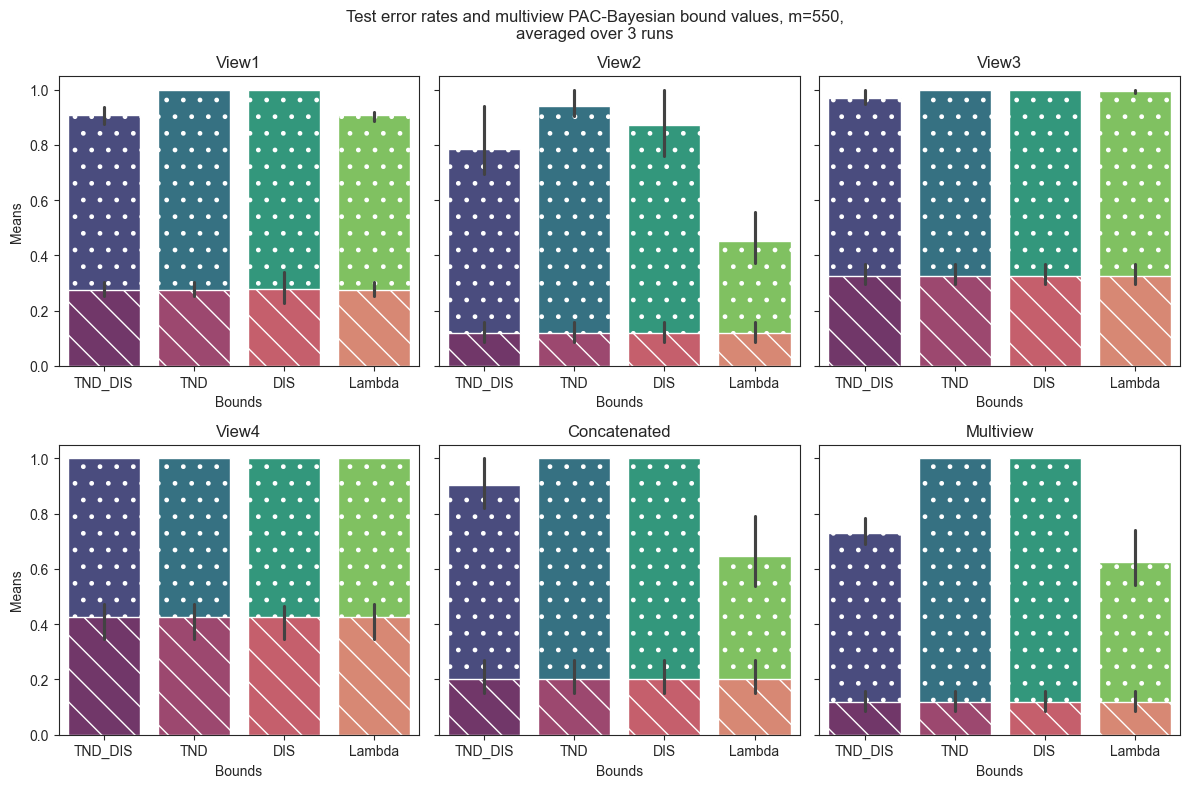

In [16]:
plot_results_grid(df, len(s_labeled["Xs_train"][0]))

In [17]:
def plot_results(experiments, m, runs=len(RUNS), bounds=BOUNDS):
    sns.set_style(style="ticks")
    bounds_palette = sns.mpl_palette("viridis", n_colors=len(bounds))
    risk_palette = sns.color_palette("flare", n_colors=len(bounds))
    risk_palette.reverse()
    
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Bound', errorbar="sd", width=0.8, hatch='.', palette=bounds_palette)
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Risk', errorbar="sd", width=0.8, hatch='\\', palette=risk_palette)

    plt.title(f'Test error rates and multiview PAC-Bayesian bound values, {m=},\naveraged over {runs} runs')
    plt.xlabel('Views')
    plt.ylabel('Means')
    
    handles, labels = ax.get_legend_handles_labels()
    labels = [labels[i]+" bound" if i < len(labels)/2 else labels[i]+" Gibbs risk" for i in range(len(labels))]

    # Creating a unified legend for both plots
    plt.legend(handles, labels, title="Bounds and risks", loc='upper right', fontsize='medium')
    plt.tight_layout() 
    plt.gcf().set_size_inches(12, 8)
    plt.show()

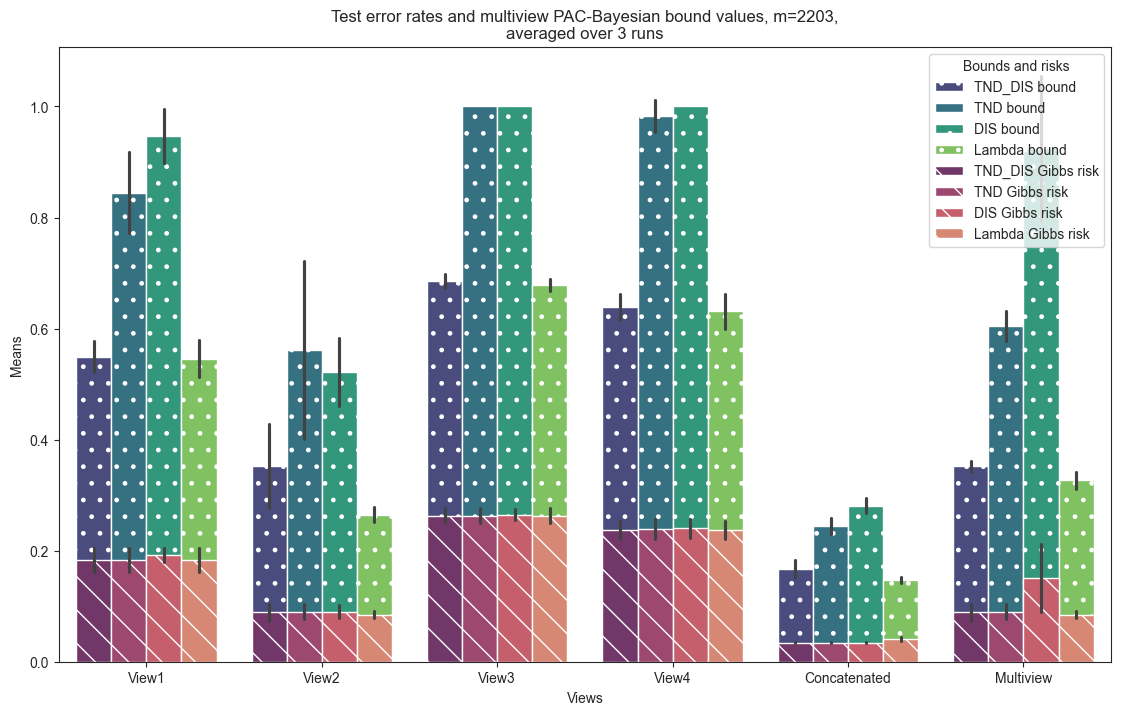

In [17]:
plot_results(df, len(s_labeled["Xs_train"][0]))